# Projeto 1 - Ciência dos Dados

Nome: Pedro Cliquet Amaral

Nome: Luciano Felix Dias

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

### Projeto


No projeto 1, iremos desenvoler um classificador de tweets a partir de um produto, que nos escolhemos o jogo League of Legends. Com base no que aprendemos durante as aulas de Ciência de Dados, iremos coletar tweets e usa-los para ensinar nossa maquina o que é relevante ou irrelevante em relação ao jogo.

### 1.1 Coleta e classificação

Usaremos um arquivo do excel para salvar o tweets coletados. Após a coleta, classificaremos manualmente a relevância deles.

___
Carregando algumas bibliotecas:

In [261]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from numpy import random

In [114]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\Cliquet\Documents\Ciencia de Dados\LC_Dados


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [115]:
filename = 'League of Legends_1.xlsx'

In [116]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Relevancia
0,@aakkari @furia tem um champ no league of lege...,0
1,@raylerchil @noideapraisso @paulokogos_ofc kkk...,0
2,a faculdade ta atrapalhando meu desempenho no ...,1
3,league of legends é pior do que perder q vida ...,1
4,eu te odeio league of legends lixo de jogo lixo,1


In [117]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Relevancia
0,uma call do supermercado vendo anime e a outra...,0
1,#pulgapreta #leagueoflegends #nimotv pulgapret...,0
2,"fico de cara que vem uns zé buceta fala ""ah ma...",0
3,@hastadvalorant esquece league of legends e ba...,0
4,saudade de jogar league of legends com elas,1


___
## Classificador automático de sentimento


Para classificar a relevância consideramos elogios, convites para jogar, críticas e formas de engajamento. Os tweets relevantes são: os elogios, críticas e convites para jogar. Já os irrelevantes são: engajamento em que a pessoa utiliza o produto para auto-divulgação e comentários com conteúdo do jogo.

### Cleaner

In [118]:
def normalize (text):
    """
        Função que normaliza os caracteres dos tweets.
    """
    text_lower = text.lower()
    matches = [
        R"[!-.\:\;\"\'/\\]",         # Pontuações
        R"\b\w{,2}\b",               # Palavras curtas
        R"[@#]\S+",                  # Marcações e Hashtags
        R"https?:\/\/\S+|www.\S+"    # Links
    ]
    match_pattern = "|".join(matches)
    pattern = re.compile(match_pattern)
    normalized = re.sub(pattern, '', text_lower)
    return normalized

### Dicionário de palavras

In [119]:
def extract_words (series):
    """
        Função que extrai as palavras de uma Series.
    """
    split = [line.split() for line in series]
    words = [word for line in split for word in line]
    
    return pd.Series(words)


### Naive-Baies

In [120]:
def P_palavra (palavra, dicio, length):
    """
        Função que calcula a probabilidade de uma palavra dado um dicionário de palavras com suavização por Naive-Bayes.
    """
    ocor = dicio[palavra] if palavra in dicio else 0
    prob = (ocor + 1) / (length + len(dicio))

    return prob


### Classificador

In [121]:
class classificador:
    def __init__ (self, df, data_column, category_column):
        self.columns = (data_column, category_column)

        data = df[data_column]
        words = extract_words(data)
        self.length = len(words)

        categories = df[category_column].cat.categories

        self.categories = {}
        for category in categories:
            cat_filter = df[category_column] == category
            filtered = df.loc[cat_filter]
            data = filtered[data_column]
            words = extract_words(data)

            self.categories[category] = {
                "table": words.value_counts(),
                "length": len(words)
            }
    
    def probabilidades (self, frase):
        normalized = normalize(frase)
        
        P_list = []
        for category, data in self.categories.items():
            table = data["table"]
            length = data["length"]
            
            P_cat = length / self.length
            P_frase_dado_cat = 1

            for palavra in normalized.split():
                P = P_palavra(palavra, table, length)
                P_frase_dado_cat *= P

            P_cat_dado_frase = P_frase_dado_cat * P_cat
            P_list.append((category, P_cat_dado_frase))

        return pd.DataFrame(P_list, columns=self.columns)

    def classifica (self, frase):
        sorted_prob = self.probabilidades(frase).sort_values(by="Relevancia", ascending=False)

        return sorted_prob.iloc[0, 0]


### Criando variáveis

In [122]:
# Normalização dos tweets
train["Treinamento"] = train["Treinamento"].apply(normalize)

# Criação das categorias de relevância
train.Relevancia = train.Relevancia.astype('category')
train.Relevancia.cat.categories = (['Irrelevante','Relevante'])

train

,Treinamento,Relevancia
0,tem champ league legends que chama akali...,Irrelevante
1,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,Irrelevante
2,faculdade atrapalhando meu desempenho leagu...,Relevante
3,league legends pior que perder vida sim,Relevante
4,odeio league legends lixo jogo lixo,Relevante
...,...,...
295,não sei continuo jogando esse jogo desgraça...,Relevante
296,larguei league legends vou voltar virar gente,Relevante
297,odeio league legends,Relevante
298,esse league legends uma puta pediu pra atual...,Relevante


In [123]:
relevante = train['Relevancia'] == 'Relevante'
train_R = train.loc[relevante]

train_R.head()

,Treinamento,Relevancia
2,faculdade atrapalhando meu desempenho leagu...,Relevante
3,league legends pior que perder vida sim,Relevante
4,odeio league legends lixo jogo lixo,Relevante
7,league legends jogo podre nojento,Relevante
8,vezes acho que fato não poder jogar league...,Relevante


In [124]:
irrelevante = train['Relevancia'] == 'Irrelevante'
train_I = train.loc[irrelevante]

train_I.head()

,Treinamento,Relevancia
0,tem champ league legends que chama akali...,Irrelevante
1,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,Irrelevante
5,unico defeito kim heechul ser diamante jog...,Irrelevante
6,league legends segredos para chegar mestre ...,Irrelevante
10,vivo jogando league legends,Irrelevante


In [125]:
classificador_tweets_lol = classificador(train, "Treinamento", "Relevancia")

In [126]:
{cat: val["length"] for cat, val in classificador_tweets_lol.categories.items()}

{'Irrelevante': 2491, 'Relevante': 1286}

In [127]:
frase = "lalaaaa bib tsd"

P_frase = classificador_tweets_lol.probabilidades(frase)

P_frase.sort_values(by="Relevancia", ascending=False).head()

,Treinamento,Relevancia
1,Relevante,5.248769e-11
0,Irrelevante,1.467939e-11


### Teste

In [128]:
test.Relevancia = test.Relevancia.astype('category')
test.Relevancia.cat.categories = (['Irrelevante','Relevante'])

test['Teste'] = test['Teste'].apply(normalize)
test

,Teste,Relevancia
0,uma call supermercado vendo anime outra jog...,Irrelevante
1,pulgapreta leagueoflegends nimotv pulgapreta e...,Irrelevante
2,fico cara que vem uns buceta fala mas tan...,Irrelevante
3,esquece league legends baixa algum moba ce...,Irrelevante
4,saudade jogar league legends com elas,Relevante
...,...,...
195,depois assalto valença que levaram meu celul...,Relevante
196,time league legends furb dos lineups fur...,Irrelevante
197,mal vejo hora chegar casa pra jogar aquele ...,Relevante
198,como bom xingar jogo league legends,Relevante


### P ser relevante ou irrelevante


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [132]:
test['verifica'] = test['Teste'].apply(classificador_tweets_lol.classifica)
test['A/E'] = test.loc[:,'verifica'] == test['Relevancia']
#test
pd.crosstab(test['verifica'],test['A/E'])

A/E,False,True
verifica,,
Irrelevante,1,15
Relevante,94,90


___
### Concluindo

* nosso classificador errou muito
* como o classificador apenas classifica como relevante e irrelevante a partir das nossas avaliações manuais do arquivo excel, ele não identifica sarcasmo e dupla negação. Entretanto, pelo formato de classificação ser binário, as caracteristicas desses comentário são irrelevantes na hora da maquina classificar.
* Uma proposta de melhoria seria adotar as caracteristicas citadas acima, e também dar importancia para a ordem das palavras. Assim a maquina poderá iterar e classificar comentários de uma forma mais realista.
* Classificar email como spam(aberto)
* Interpretação de texto via machine learning
* Por que eles devem continuar financiando o seu projeto? por que ao expandir a forma do classificador no questio interpretação, podemos identificar eventuais problemas que os consumidores estão passando, ou pontos que mantem-os como fieis jogadores. E isso pode ajudar nas melhorias a longo prazo, e quissá, trazer novos players com os feedbacks positivos que a empresa terá ROUBANDO DADOS DA GALERA PELO TWITI!

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [269]:
test_reset = pd.read_excel(filename, sheet_name = 'Teste')
train_reset = pd.read_excel(filename)
test_reset['Tweet'] = test_reset['Teste']
train_reset['Tweet'] = train_reset['Treinamento']
del train_reset['Treinamento']
del test_reset['Teste']


In [345]:

lister = train_reset.append(test_reset,ignore_index=True)

lister["Tweet"] = lister["Tweet"].apply(normalize)
lister.Relevancia = lister.Relevancia.astype('category')
lister.Relevancia.cat.categories = (['Irrelevante','Relevante'])
acerto_R_list = []
acerto_I_list = []
erro_R_list = []
erro_I_list = []

for i in range(100):
    lister_2 = lister.reindex(random.permutation(lister.index))
    novo_test = lister_2.iloc[0:200]
    novo_train = lister_2.iloc[200:500]

    classificador_tweets_lol = classificador(novo_train, "Tweet", "Relevancia")
    novo_test['verifica'] = novo_test['Tweet'].apply(classificador_tweets_lol.classifica)

    #pd.crosstab(novo_test['Relevancia'],novo_test['verifica'])

    novo_test['A/E'] = novo_test.loc[:,'verifica'] == novo_test['Relevancia']
    #test
    cros = pd.crosstab(novo_test['verifica'],novo_test['A/E'],normalize=True)
    acerto_R = cros.loc['Relevante',True]
    acerto_I = cros.loc['Irrelevante',True]
    erro_R = cros.loc['Relevante',False]
    erro_I = cros.loc['Irrelevante',False]

    acerto_R_list.append(acerto_R)
    acerto_I_list.append(acerto_I)
    erro_R_list.append(erro_R)
    erro_I_list.append(erro_I)

<ipython-input-345-43c7765dcfe6>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novo_test['verifica'] = novo_test['Tweet'].apply(classificador_tweets_lol.classifica)
<ipython-input-345-43c7765dcfe6>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  novo_test['A/E'] = novo_test.loc[:,'verifica'] == novo_test['Relevancia']


In [ ]:
print(acerto_R_list)
print(acerto_I_list)
print(erro_R_list)
print(erro_I_list)

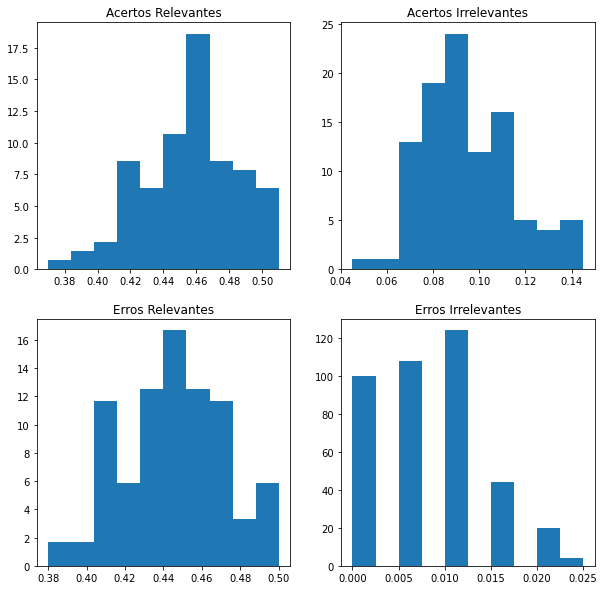

In [349]:
fig= plt.figure(figsize=(10,10))


plt.subplot(2,2,1)
plt.hist(acerto_R_list, density=True)
plt.title('Acertos Relevantes')


plt.subplot(2,2,2)
plt.hist(acerto_I_list, density=True)
plt.title('Acertos Irrelevantes')




plt.subplot(2,2,3)
plt.hist(erro_R_list, density=True)
plt.title('Erros Relevantes')


plt.subplot(2,2,4)
plt.hist(erro_I_list, density=True)
plt.title('Erros Irrelevantes')

plt.show()

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* Limpar: \n, :, ", ', (, ), etc SEM remover emojis
* Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis
* Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação
* Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B)
* Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* Propor diferentes cenários para Naïve Bayes fora do contexto do projeto
* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)


___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**